In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import scienceplots
%matplotlib inline

from nanonets.utils import prepare_for_fitness_calculation, fitness, abundance, abundance_plot, get_best_logic_gate, nonlinear_parameter, return_ndr, return_nls

# PATH    = "/home/jonasmensing/bagheera/data/2_funding_period/static/res_disorder/"
# PATH_U  = "/home/jonasmensing/bagheera/data/1_funding_period/system_size/"

PATH    = "/home/j/j_mens07/bagheera/data/2_funding_period/static/res_disorder/"
PATH_U  = "/home/j/j_mens07/bagheera/data/1_funding_period/system_size/"
V_IN    = 0.01
DELTA   = 0.0
MAX_ERROR = 0.1
GATES   = ['AND', 'OR', 'XOR', 'NAND', 'NOR', 'XNOR']
plt.style.use(["science","bright","grid"])

In [4]:
data_50  = {}
data_100 = {}
data_200 = {}
df_u    = pd.read_csv(f"{PATH_U}Nx=9_Ny=9_Ne=8.csv")
df_u    = df_u[(df_u['Error']/df_u['Observable']).abs() < MAX_ERROR].reset_index(drop=True)
df_u    = prepare_for_fitness_calculation(df_u, N_e=8, input_cols=["E1","E3"])
df_dis_50  = pd.DataFrame()
for i in range(64):
    df      = pd.read_csv(f"{PATH}Nx=9_Ny=9_Ne=8_mean2_50.0_{i}.csv")
    df      = df[(df['Error']/df['Observable']).abs() < MAX_ERROR].reset_index(drop=True)
    df      = prepare_for_fitness_calculation(df, N_e=8, input_cols=["E1","E3"])
    df_dis_50  = pd.concat((df_dis_50,df),ignore_index=True)
    data_50[i] = df

df_dis_100  = pd.DataFrame()
for i in range(64):
    df      = pd.read_csv(f"{PATH}Nx=9_Ny=9_Ne=8_mean2_100.0_{i}.csv")
    df      = df[(df['Error']/df['Observable']).abs() < MAX_ERROR].reset_index(drop=True)
    df      = prepare_for_fitness_calculation(df, N_e=8, input_cols=["E1","E3"])
    df_dis_100  = pd.concat((df_dis_100,df),ignore_index=True)
    data_100[i] = df

df_dis_200  = pd.DataFrame()
for i in range(64):
    df      = pd.read_csv(f"{PATH}Nx=9_Ny=9_Ne=8_mean2_200.0_{i}.csv")
    df      = df[(df['Error']/df['Observable']).abs() < MAX_ERROR].reset_index(drop=True)
    df      = prepare_for_fitness_calculation(df, N_e=8, input_cols=["E1","E3"])
    df_dis_200  = pd.concat((df_dis_200,df),ignore_index=True)
    data_200[i] = df

In [ ]:
fitness_data_u          = fitness(df_u, input_cols=["E1","E3"], on_state=0.01, delta=DELTA)
abundance_data_u        = abundance(fitness_data_u)
fitness_data_dis_50     = fitness(df_dis_50, input_cols=["E1","E3"], on_state=0.01, delta=DELTA)
abundance_data_dis_50   = abundance(fitness_data_dis_50)
fitness_data_dis_100    = fitness(df_dis_100, input_cols=["E1","E3"], on_state=0.01, delta=DELTA)
abundance_data_dis_100  = abundance(fitness_data_dis_100)
fitness_data_dis_200    = fitness(df_dis_200, input_cols=["E1","E3"], on_state=0.01, delta=DELTA)
abundance_data_dis_200  = abundance(fitness_data_dis_200)

In [6]:
df1 = fitness_data_u.loc[:,'AND Fitness':]
df1.columns = GATES
df1 = df1.melt(var_name='Gate', value_name='$Fitness$')
df1['Disorder'] = 25

df2 = fitness_data_dis_50.loc[:,'AND Fitness':]
df2.columns = GATES
df2 = df2.melt(var_name='Gate', value_name='$Fitness$')
df2['Disorder'] = 50

df3 = fitness_data_dis_100.loc[:,'AND Fitness':]
df3.columns = GATES
df3 = df3.melt(var_name='Gate', value_name='$Fitness$')
df3['Disorder'] = 100

df4 = fitness_data_dis_200.loc[:,'AND Fitness':]
df4.columns = GATES
df4 = df4.melt(var_name='Gate', value_name='$Fitness$')
df4['Disorder'] = 200

fitness_melted = pd.concat([df1,df2,df3,df4],ignore_index=True)
fitness_melted

,Gate,$Fitness$,Disorder
0,AND,3.048711,25
1,AND,3.417096,25
2,AND,4.455492,25
3,AND,3.913606,25
4,AND,6.101355,25
...,...,...,...
8506657,XNOR,-0.434008,200
8506658,XNOR,-0.668794,200
8506659,XNOR,0.943990,200
8506660,XNOR,-0.319196,200


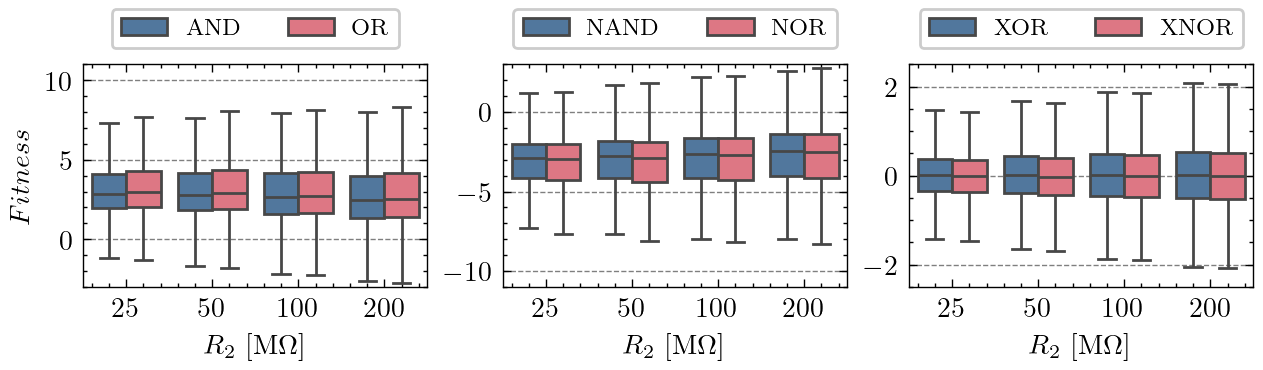

In [95]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.8)
fig.set_figheight(fig.get_figheight()*0.7)

for i, g_comb in enumerate([['AND','OR'],['NAND','NOR'],['XOR','XNOR']]):

    ax  = fig.add_subplot(1,3,i+1)
    ax  = sns.boxplot(data=fitness_melted[(fitness_melted['Gate']==g_comb[0])|(fitness_melted['Gate']==g_comb[1])],
                      x='Disorder', y='$Fitness$', hue='Gate', ax=ax, fliersize=0)
    # ax  = sns.violinplot(data=fitness_melted[(fitness_melted['Gate']==g_comb[0])|(fitness_melted['Gate']==g_comb[1])],
    #                   x='Disorder', y='$Fitness$', hue='Gate', ax=ax, cut=0, density_norm='width', inner='point')
    leg = ax.legend(loc='center', bbox_to_anchor=(0.5,1.16), ncol=2, fontsize='small')
    leg.set_in_layout(True)
    if i != 0:
        ax.set_ylabel("")
    if i == 0:
        ax.set_ylim(-3,11)
    elif i == 1:
        ax.set_ylim(-11,3)
    else:
        ax.set_ylim(-2.5,2.5)
    ax.set_xlabel("$R_2$ [M$\Omega$]")
    
fig.savefig("plots/res_disorder/png/box_plots_vs_res.png",transparent=False)
fig.savefig("plots/res_disorder/pdf/box_plots_vs_res.pdf",transparent=False)
fig.savefig("plots/res_disorder/svg/box_plots_vs_res.svg",transparent=True)

In [42]:
ndr_l = {
    25  : return_ndr(nonlinear_parameter(df_u)['Ml']),
    50  : [return_ndr(nonlinear_parameter(data_50[n])['Ml']) for n in range(64)],
    100 : [return_ndr(nonlinear_parameter(data_100[n])['Ml']) for n in range(64)],
    200 : [return_ndr(nonlinear_parameter(data_200[n])['Ml']) for n in range(64)]
    }
ndr_r = {
    25  : return_ndr(nonlinear_parameter(df_u)['Mr']),
    50  : [return_ndr(nonlinear_parameter(data_50[n])['Mr']) for n in range(64)],
    100 : [return_ndr(nonlinear_parameter(data_100[n])['Mr']) for n in range(64)],
    200 : [return_ndr(nonlinear_parameter(data_200[n])['Mr']) for n in range(64)]
    }
nls = {
    25  : return_nls(nonlinear_parameter(df_u)),
    50  : [return_nls(nonlinear_parameter(data_50[n])) for n in range(64)],
    100 : [return_nls(nonlinear_parameter(data_100[n])) for n in range(64)],
    200 : [return_nls(nonlinear_parameter(data_200[n])) for n in range(64)]
    }

In [89]:
df_nls = pd.DataFrame()
for key, vals in nls.items():
    df_tmp          = pd.DataFrame()
    if type(vals) == np.float64:
        df_tmp['nls']   = np.repeat(vals,10)
    else:
        df_tmp['nls']   = vals
    df_tmp['R']     = key
    df_nls          = pd.concat([df_nls, df_tmp], ignore_index=True)
df_ndr = pd.DataFrame()
for key in ndr_l.keys():
    df_tmp_l        = pd.DataFrame()
    if type(ndr_l[key]) is np.float64:
        df_tmp_l['ndr'] = np.repeat(ndr_l[key],10)
    else:
        df_tmp_l['ndr'] = ndr_l[key]
    df_tmp_l['R']   = key
    df_tmp_l['o']   = 'left'
    df_tmp_r        = pd.DataFrame()
    if type(ndr_r[key]) is np.float64:
        df_tmp_r['ndr'] = np.repeat(ndr_r[key],10)
    else:
        df_tmp_r['ndr'] = ndr_r[key]
    df_tmp_r['R']   = key
    df_tmp_r['o']   = 'right'
    df_tmp          = pd.concat([df_tmp_l, df_tmp_r], ignore_index=True)
    df_ndr          = pd.concat([df_ndr, df_tmp], ignore_index=True)

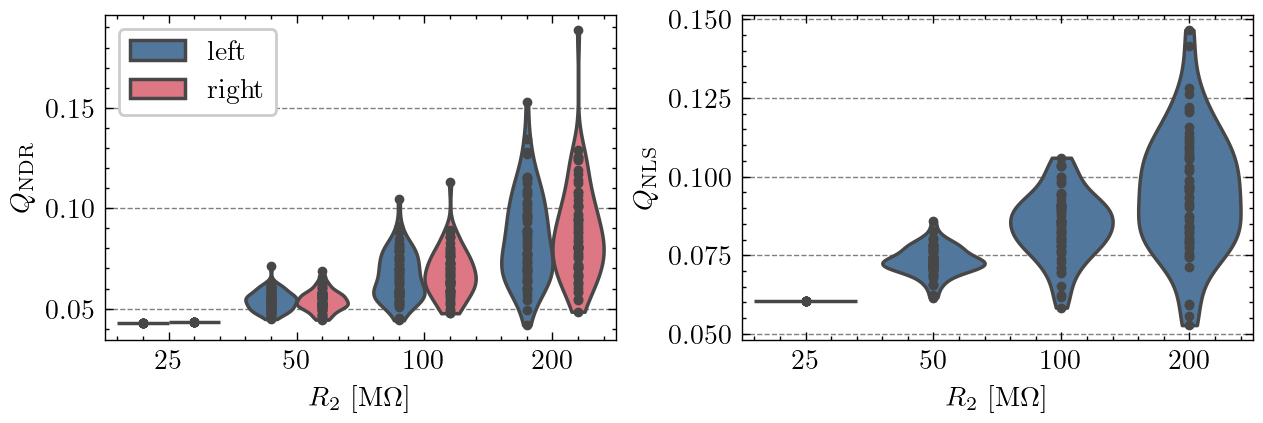

In [93]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.8)
fig.set_figheight(fig.get_figheight()*0.8)
ax  = fig.add_subplot(1,2,1)
sns.violinplot(data=df_ndr, x='R', y='ndr', hue='o', cut=0, density_norm='width', inner='point')
sns.move_legend(ax, 'upper left', title='')
ax.set_xlabel("$R_2$ [M$\Omega$]")
ax.set_ylabel("$Q_{\\text{NDR}}$")

ax  = fig.add_subplot(1,2,2)
sns.violinplot(data=df_nls, x='R', y='nls', cut=0, density_norm='width', inner='point')
ax.set_ylabel("$Q_{\\text{NLS}}$")
ax.set_xlabel("$R_2$ [M$\Omega$]")

fig.savefig("plots/res_disorder/png/nonlinear_params_box_plots_vs_res.png",transparent=False)
fig.savefig("plots/res_disorder/pdf/nonlinear_params_box_plots_vs_res.pdf",transparent=False)
fig.savefig("plots/res_disorder/svg/nonlinear_params_box_plots_vs_res.svg",transparent=True)

In [ ]:
# Current Relations
n_bootstrap = 100
params      = [nonlinear_parameter(df, on_state=0.01, n_bootstrap=n_bootstrap) for df in [df_u, df_dis_50, df_dis_100, df_dis_200]]

# NDR / NLS
bins    = 'fd'
Q_ndr   = []
Q_nls   = []
for i in range(n_bootstrap): 

    Q_ndr_l =   np.array([return_ndr(params[n][i]['Ml']) for n in range(4)])
    Q_ndr_r =   np.array([return_ndr(params[n][i]['Mr']) for n in range(4)])
    Q_ndr.append((Q_ndr_l + Q_ndr_r) / 2)

    Q_nls.append(np.array([return_nls(df=params[n][i], bins=bins) for n in range(4)]))

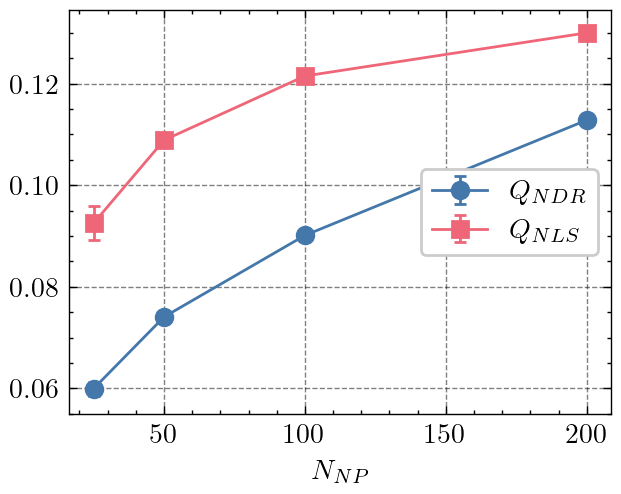

In [19]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    
    ax.errorbar([25,50,100,200], np.mean(Q_ndr,axis=0), 1.96*np.std(Q_ndr,axis=0), marker='o', label='$Q_{NDR}$', capsize=2)
    ax.errorbar([25,50,100,200], np.mean(Q_nls,axis=0), 1.96*np.std(Q_nls,axis=0), marker='s', label='$Q_{NLS}$', capsize=2)

    ax.set_xlabel('$N_{NP}$')
    ax.legend(loc='center right')
    # ax.set_ylim(0.1,0.5)
    # ax.set_yticklabels("")
    # ax.grid(False)

fig.savefig("plots/res_disorder/png/nonlinear_params_vs_res.png",transparent=False)
fig.savefig("plots/res_disorder/pdf/nonlinear_params_vs_res.pdf",transparent=False)
fig.savefig("plots/res_disorder/svg/nonlinear_params_vs_res.svg",transparent=True)

# fig.savefig("plots/res_disorder/nonlinear_params.svg", transparent=True)
# fig.savefig("../plots/scaled_nonlinearity_vs_system_size_scaled.pdf", transparent=False, bbox_inches='tight')

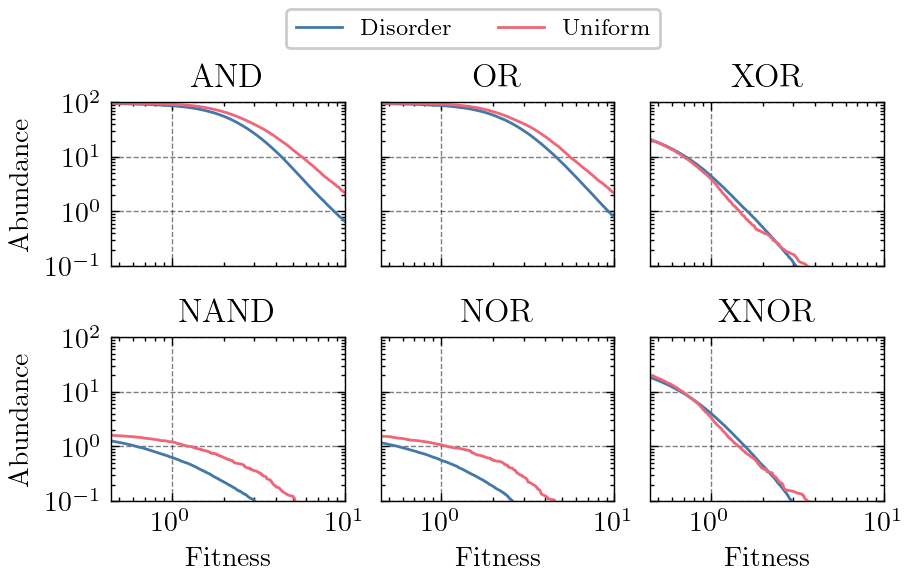

In [9]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.3)

for i, gate in enumerate(GATES):
    
    ax     = fig.add_subplot(2,3,i+1)
    x1, y1 = abundance_data_dis[f'{gate} Fitness'], abundance_data_dis[f'{gate} Fitness Abundance']
    x4, y4 = abundance_data_u[f'{gate} Fitness'], abundance_data_u[f'{gate} Fitness Abundance']

    ax.plot(x1,y1, label='Disorder')
    ax.plot(x4,y4, label='Uniform')

    ax.set_xlim(0.45,10)
    ax.set_ylim(0.1,100)
    ax.set_yscale('log')
    ax.set_xscale('log')

    if i % 3 == 0:
        ax.set_ylabel("Abundance")
    else:
        ax.set_yticklabels("")
    if i >= 3:
        ax.set_xlabel("Fitness")
    else:
        ax.set_xticklabels("")
    ax.set_title(gate)

    if i==0:
        leg = ax.legend(loc='center', bbox_to_anchor=(1.55,1.45), ncol=6, fontsize='small')

leg.set_in_layout(False)
fig.canvas.draw()
leg.set_in_layout(True)
fig.set_layout_engine('none')

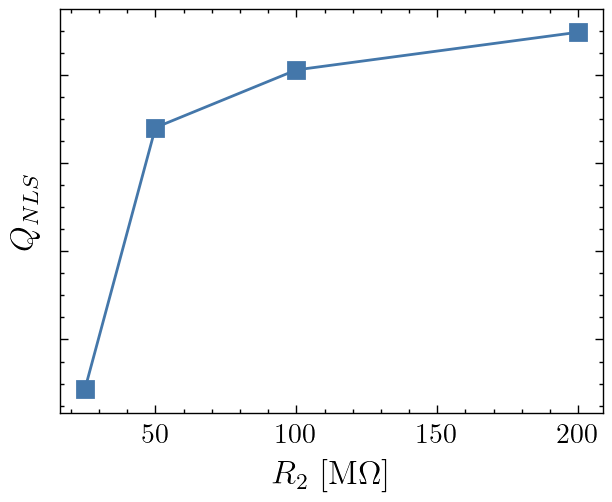

In [40]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    
    ax.errorbar([25,50,100,200], np.mean(Q_nls,axis=0), 1.96*np.std(Q_nls,axis=0), marker='s', label='$Q_{NLS}$', capsize=2)

    ax.set_xlabel('$R_2$ [M$\Omega$]', fontsize='large')
    # ax.legend(loc='center right')
    # ax.set_ylim(0.1,0.5)
    ax.set_yticklabels("")
    ax.grid(False)
    ax.set_ylabel("$Q_{NLS}$", fontsize='large')

fig.savefig("plots/res_disorder/nonlinear_params_nls.svg", transparent=True)
# fig.savefig("../plots/scaled_nonlinearity_vs_system_size_scaled.pdf", transparent=False, bbox_inches='tight')

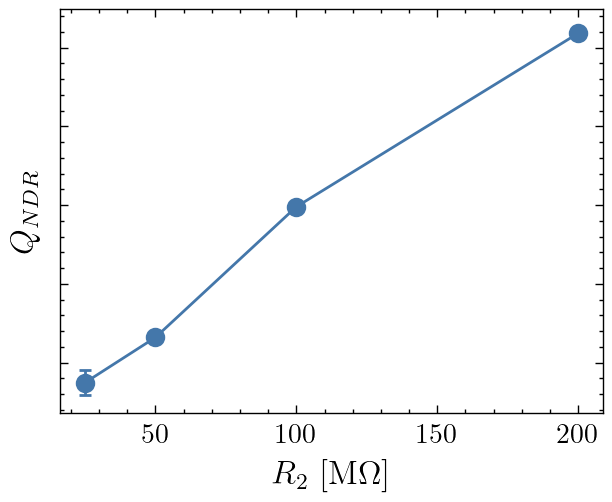

In [41]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    
    ax.errorbar([25,50,100,200], np.mean(Q_ndr,axis=0), 1.96*np.std(Q_ndr,axis=0), marker='o', label='$Q_{NDR}$', capsize=2)

    ax.set_xlabel('$R_2$ [M$\Omega$]', fontsize='large')
    # ax.legend(loc='center right')
    ax.set_ylabel("$Q_{NDR}$", fontsize='large')
    # ax.set_ylim(0.1,0.5)
    ax.set_yticklabels("")
    ax.grid(False)

fig.savefig("plots/res_disorder/nonlinear_params_ndr.svg", transparent=True)
# fig.savefig("../plots/scaled_nonlinearity_vs_system_size_scaled.pdf", transparent=False, bbox_inches='tight')

In [12]:
df_comp = pd.DataFrame()
for i in range(64):
    df1 = fitness_data[i].loc[:,'AND Fitness':]
    df1.columns = GATES
    df1 = df1.melt(var_name='Gate', value_name='$Fitness$')
    df1['Disorder'] = i
    df_comp = pd.concat((df_comp,df1),ignore_index=True)

df1 = fitness_data_u.loc[:,'AND Fitness':]
df1.columns = GATES
df1 = df1.melt(var_name='Gate', value_name='$Fitness$')
df1['Disorder'] = -1

df_comp = pd.concat([df_comp, df1], ignore_index=True)
df_comp

,Gate,$Fitness$,Disorder
0,AND,9.398278,0
1,AND,1.351152,0
2,AND,6.300581,0
3,AND,1.803353,0
4,AND,17.134290,0
...,...,...,...
417493,XNOR,0.002194,-1
417494,XNOR,-0.009091,-1
417495,XNOR,0.082449,-1
417496,XNOR,0.282562,-1


Text(0.5, 0, '$\\sigma_F$')

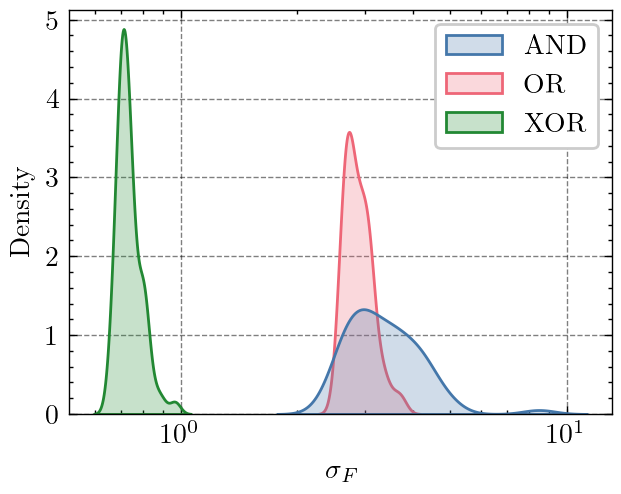

In [13]:
df = pd.DataFrame([[fitness_data[i][f'{gate} Fitness'].std() for i in range(64)] for gate in ['AND','OR','XOR']]).T
df.columns = ['AND','OR','XOR']
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.kdeplot(df, ax=ax, log_scale=True, fill=True)
ax.set_xlabel("$\sigma_F$")

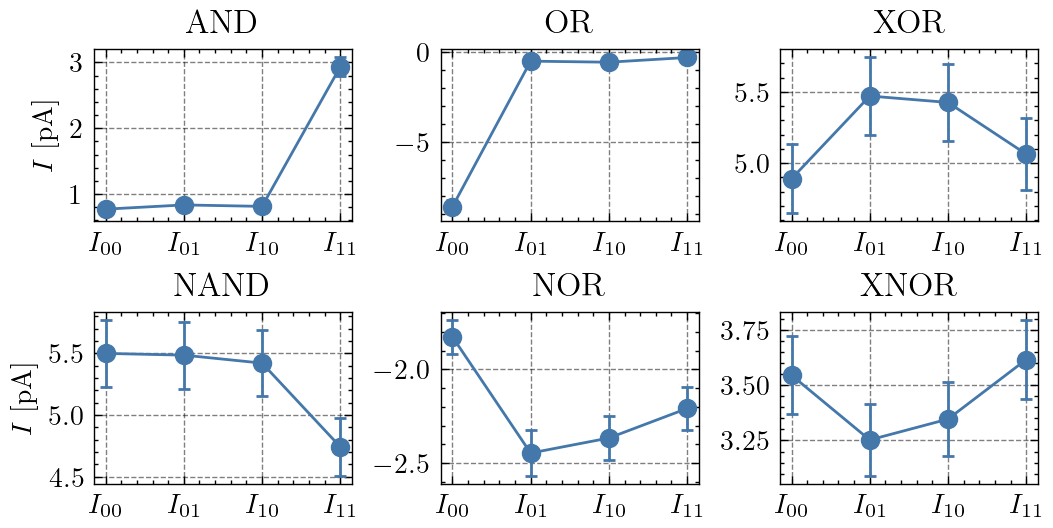

In [15]:
n   = 12
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.5)
for i, gate in enumerate(GATES):
    ax = fig.add_subplot(2,3,i+1)
    best_gate = get_best_logic_gate(data[n], fitness_data[n], gate)
    ax.errorbar([0,1,2,3], best_gate['Observable'].values*1e-6, best_gate['Error'].values*1e-6, marker='o', capsize=2)
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(["$I_{00}$","$I_{01}$","$I_{10}$","$I_{11}$"])
    ax.set_title(gate)
    if i % 3 == 0:
        ax.set_ylabel("$I$ [pA]")